In [45]:
# Double Down Betting: Bet the moneyline on a team. If they lose, double the same bet for the same team in their next game.

# The purpose of this notebook is to see if this would be profitable for the 2021 Detroit Tigers

# Data sources

# 2021
# https://www.baseball-reference.com/teams/DET/2021-schedule-scores.shtml
# https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers

# 2019
# https://www.baseball-reference.com/teams/DET/2019-schedule-scores.shtml
# https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers/2019

# 2018
# same as above

# terminology
# team-season: a specific season for a specific team
# refill factor: the length of games you're guaranteed until another refill
# dataset name: a 4-5 letter string of the team abbreviation + last 2 digits of season year

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
import statistics

In [47]:
# functions to help process one column of data
def res(s):
    return s[0]
def line(s):
    return s[2:]

def process_data(fname): 
    """
    Processes an individual file into a pandas Dataframe
  
    Parameters:
    fname (str): file name
  
    Returns:
    df (pd.DataFrame): processed team-season data
    """
    df = pd.read_csv(join("data", fname), encoding= 'unicode_escape')
    df['result'] = df['result and moneyline'].apply(res)
    df['line'] = df['result and moneyline'].apply(line).apply(int)
    df.drop('result and moneyline', 1, inplace = True)
    df.sort_values(by=['game'], inplace=True)
    return df

def sim_szn(ds_name, base_bet, start_balance, r):
    """
    Carries out a season of Martingale betting using the data for an individual team-season
  
    Parameters:
    ds_name (str): dataset name
    base_bet (int): base bet amount
    start_balance (int): balance at beginning of season
    r (int): refill factor
  
    Returns:
    df (pd.DataFrame): full team-season bet data
    """
    df = process_data(ds_name)
    curr_bet = base_bet
    balance = start_balance
    earnings = 0
    bet_hist = []
    payout_hist = []
    balance_hist = []
    earnings_hist = []

    for index, row in df.iterrows():
        payout = 0
        if curr_bet > balance: #  losing streak has overwhelmed balance
            curr_bet = base_bet # reset current bet
            if curr_bet > balance: # refill account
                earnings -= ((2**r - 1) * base_bet - balance)
                balance = (2**r - 1) * base_bet * 7
        bet_hist.append(curr_bet)
        if row['result'] == 'W': # team wins
            if (row['line'] > 0): # underdog
                payout = round(0.01 * row['line'] * curr_bet, 2)
            else: # favorite
                payout = round(-100 / row['line'] * curr_bet, 2)
            curr_bet = base_bet # reset
        else: # team loses
            payout = curr_bet * -1
            curr_bet = curr_bet * 2 # double down
        balance += payout
        earnings += payout
        payout_hist.append(payout)
        balance_hist.append(balance)
        earnings_hist.append(earnings)
    
    df['bet'] = bet_hist
    df['payout'] = payout_hist
    df['balance'] = balance_hist
    df['earnings'] = earnings_hist
    
    return df

def full_run(ds_names, base_bet=4, start_balance=50, r=2):
    """
    Carries out season for all teams listed in ds_names parameter
    note: parameter defaults are arbitrary
  
    Parameters:
    ds_names (list of str's): list of dataset names
    base_bet (int): see sim_szn function
    start_balance (int): see sim_szn function
    r (int): see sim_szn function
  
    Returns:
    bet_data (dict): maps dataset names to each team-season's data
    team_data (pd.DataFrame): contains aggregate data for each team-season
    """
    datasets, wins, earnings = [],[],[]
    bet_data = {}
    for i in range(len(ds_names)):
        datasets.append(sim_szn(ds_names[i] + ".csv", base_bet, start_balance, r))
        bet_data[ds_names[i]] = datasets[i]
    for df in bet_data:
        wins.append(bet_data[df]["result"].value_counts()["W"])
        earnings.append(bet_data[df].iloc[len(bet_data[df].index) - 1]['earnings'])
    team_data = pd.DataFrame({'Name':ds_names, 'Wins': wins, 'Earnings': earnings})
    team_data.sort_values(by=['Wins'], inplace=True)
    return bet_data, team_data

In [48]:
# derived from filenames in data directory
ds_names = ["det21", "chw21", "cle21", "kc21", "min21", "tb21", "bos21", "nyy21", "tor21", "bal21", "hou21", "sea21",
            "oak21", "laa21", "tex21"]

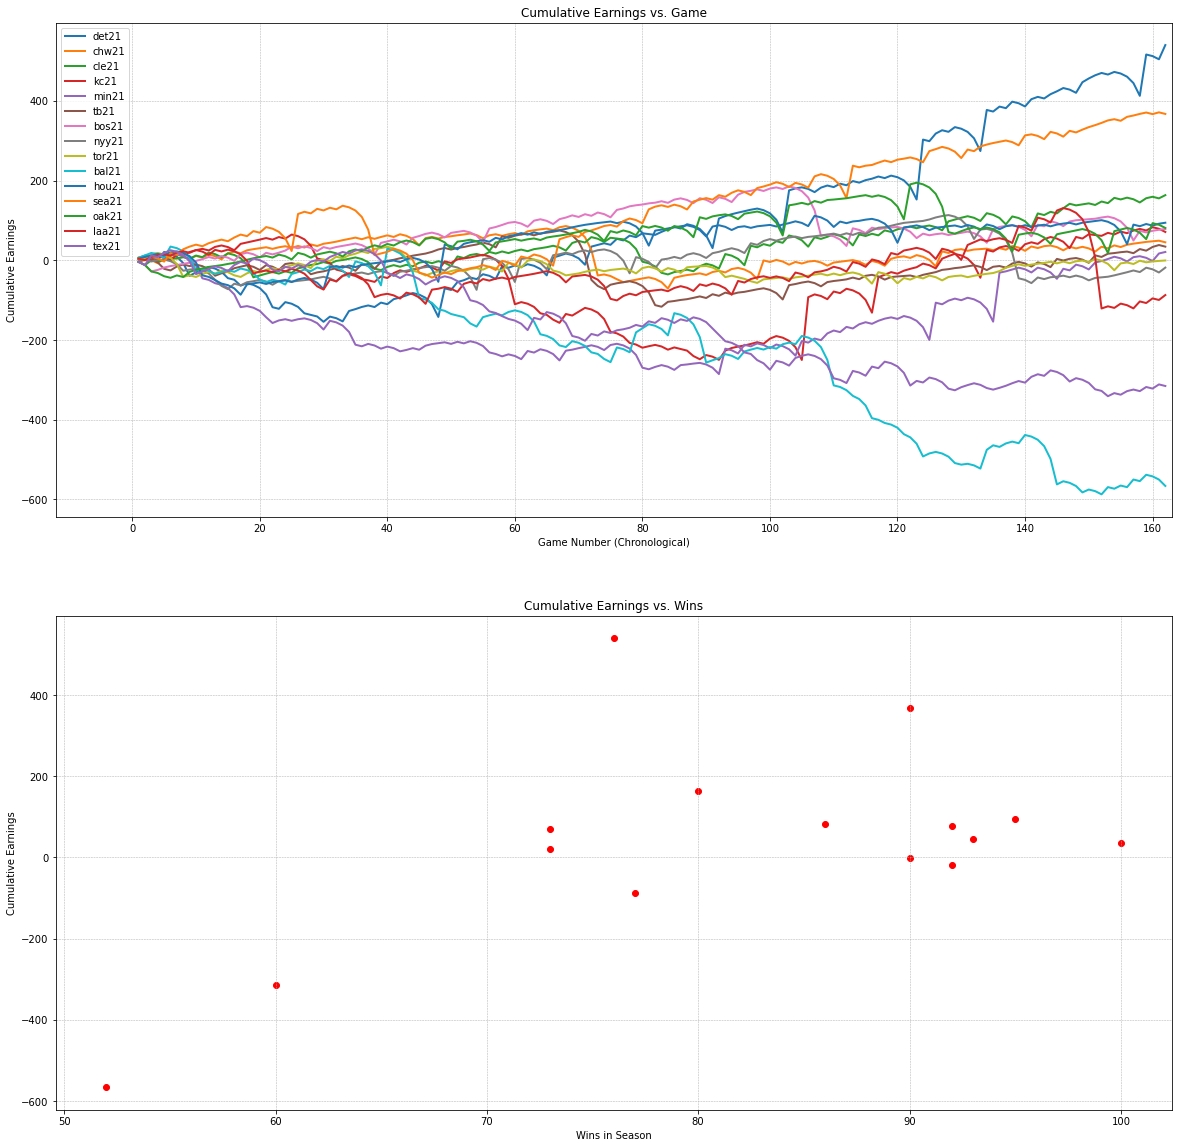

In [49]:
# run once with default parameters
bet_data, team_data = full_run(ds_names)

# plot results
mpl.rcParams["figure.figsize"] = [20,20]
fig, (ax1, ax2) = plt.subplots(2)

for df in bet_data:
    x = bet_data[df]['game']
    y = bet_data[df]['earnings']
    ax1.plot(x, y, lw = 2, label = df)

ax1.grid(linestyle = '--', linewidth = 0.5)
ax1.set_title("Cumulative Earnings vs. Game")
ax1.set_xlabel("Game Number (Chronological)")
ax1.set_ylabel("Cumulative Earnings")
ax1.legend(loc='upper left')
ax1.set_xlim(-12, 163)

ax2.grid(linestyle = '--', linewidth = 0.5)
ax2.set_title("Cumulative Earnings vs. Wins")
ax2.set_xlabel("Wins in Season")
ax2.set_ylabel("Cumulative Earnings")
ax2.scatter(team_data['Wins'], team_data['Earnings'], color = "r")

In [52]:
# grid search

df = pd.DataFrame({'base_bet': [], 'starting_balance': [], 'refill': [], 'earn_avg': [], 'earn_sd': [], 'avg_earn61': [], 'percent_pos': []})
for i in [2,5,10,20]: # base_bet
    for j in [25,50,100,200,1000]: # starting_balance
        for k in [2,3,4,5,6]: # refill
            bet_data, team_data = full_run(ds_names, i, j, k)
            team_data_61_wins = team_data[team_data['Wins'] > 60]
            team_data_pos_earn = team_data[team_data['Earnings'] > 0]
            avg1 = round(statistics.mean(team_data['Earnings']), 2) # Avg Team Earnings
            sd1 = round(statistics.stdev(team_data['Earnings']), 2) # St. Dev Team Earnings
            avg2 = round(statistics.mean(team_data_61_wins['Earnings']), 2) # Avg Team Earnings, >60 Wins
            avg3 = round(100 * len(team_data_pos_earn) / len(team_data), 2) # Percent of teams with positive earnings
            df = df.append({'base_bet': i, 'starting_balance': j, 'refill': k, 'earn_avg': avg1, 'earn_sd': sd1, 'avg_earn61': avg2, 'percent_pos': avg3}, ignore_index = True)
print('grid search complete')

grid search complete


In [54]:
# analyze results of grid search

df.sort_values(by=['avg_earn61'], inplace=True, ascending=False)
display(df.head(10))
df.sort_values(by=['earn_avg'], inplace=True, ascending=False)
display(df.head(10))
df.sort_values(by=['percent_pos'], inplace=True, ascending=False)
display(df.head(10))

,base_bet,starting_balance,refill,earn_avg,earn_sd,avg_earn61,percent_pos
77,20.0,25.0,4.0,37.54,2689.81,716.44,60.00
95,20.0,1000.0,2.0,126.94,1689.38,507.16,46.67
85,20.0,100.0,2.0,215.84,1162.73,503.01,60.00
82,20.0,50.0,4.0,111.06,1902.04,447.50,60.00
92,20.0,200.0,4.0,-234.23,2512.12,444.22,60.00
91,20.0,200.0,3.0,19.93,1422.38,427.94,53.33
97,20.0,1000.0,4.0,-82.03,2049.70,417.26,53.33
86,20.0,100.0,3.0,32.04,1450.45,416.41,60.00
87,20.0,100.0,4.0,4.21,1926.83,383.64,53.33
96,20.0,1000.0,3.0,5.77,1789.24,368.75,46.67


,base_bet,starting_balance,refill,earn_avg,earn_sd,avg_earn61,percent_pos
85,20.0,100.0,2.0,215.84,1162.73,503.01,60.00
95,20.0,1000.0,2.0,126.94,1689.38,507.16,46.67
48,5.0,1000.0,5.0,118.71,649.73,269.08,60.00
71,10.0,1000.0,3.0,117.09,1173.79,242.17,40.00
80,20.0,50.0,2.0,113.74,1184.16,348.17,46.67
47,5.0,1000.0,4.0,113.21,637.48,269.08,60.00
82,20.0,50.0,4.0,111.06,1902.04,447.50,60.00
55,10.0,50.0,2.0,107.89,581.37,251.47,60.00
46,5.0,1000.0,3.0,82.20,695.12,269.08,60.00
45,5.0,1000.0,2.0,78.45,700.44,269.08,60.00


,base_bet,starting_balance,refill,earn_avg,earn_sd,avg_earn61,percent_pos
21,2.0,1000.0,3.0,-74.77,534.78,78.98,80.00
24,2.0,1000.0,6.0,-142.92,704.89,48.64,80.00
22,2.0,1000.0,4.0,-61.10,507.62,85.51,80.00
20,2.0,1000.0,2.0,-66.72,521.06,92.57,80.00
23,2.0,1000.0,5.0,-85.59,572.29,73.24,80.00
53,10.0,25.0,5.0,-237.87,1373.72,62.68,66.67
78,20.0,25.0,5.0,-648.98,3572.02,259.21,66.67
0,2.0,25.0,2.0,16.91,126.36,53.43,66.67
83,20.0,50.0,5.0,-475.70,2747.44,125.40,66.67
2,2.0,25.0,4.0,-4.43,249.80,66.48,60.00


In [ ]:
# todo
# add previous years, 2021 NL